# Diagnosistic Help

Author: Ethan Goan

Version: 1.0

Date: 11-03-24

Anyone who has done any amount of software development will know that it's not a matter of if things will go wrong, it's only a matter of when. This notebook will contain a walkthrough of some common errors we have seen students make over the past few years, some hints for diagnosing whats going on and why, and solutions to these errors. It is hoped that this notebook will serve as a bit of a first port of call for whatever issues you might encounter throughout CAB420. I will put a bit of narrative around the topics here so you can maybe get a bit more of an understanding, but this isn't something here that we expect you all to read from top to bottom. This is more along the lines of you should be able to `Ctrl-f` what you need, and then maybe just read the section for things giving you grief.

We will use the term "error" here in a more broad sense, where "error" means things simply not working as you intended. This could include python spitting some red wall of text at you for a programming error, or a model failing to yield any meaningful output when put to the test. 



In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import glob
import pickle
import random
import pandas
import cv2
import numpy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, GlobalAveragePooling2D
from keras import activations
from keras.regularizers import l2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
keras.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# don't worry about this, this is just so I can add a magic command that will continue to run a cell
# if there is an error.
from IPython.core.magic import register_cell_magic

@register_cell_magic('handle')
def handle(line, cell):
    try:
#         exec(cell)  # doesn't return the cell output though
        return eval(cell)
    except Exception as exc:
        print(f"\033[1;31m{exc.__class__.__name__} : \033[1;31;47m{exc}\033[0m")
#         raise # if you want the full trace-back in the notebook


## DCNN Training Mistakes

It is pretty easy to make simple mistakes when fitting neural networks. Hopefully highlighting some of these here will save you all a bit of time down the track.



### Setting from_logits incorrectly

As we have discussed in class, for a classification model the loss function we will most often be using is the categorical cross entropy (is derived from negative log-likelihood for categorical distributions). For binary classifications, we will need the binary cross entropy loss. To remind ourselves, the output of model will be of the form,

$$
y = \text{Softmax}(\text{logit})
$$

where $\text{logit}$ will be the final output of our model. For Binary classification, it will be,

$$
y = \text{Sigmoid}(\text{logit})
$$


This is to say that the $\text{Softmax}$ (or Sigmoid) function will turn the $\text{logit}$ into probability. The loss function is derived for the proability output $y$, so you might think that it always just makes sense to bake in the $\text{Softmax}$ module directly into the network definition right? Well you could do this, but there are times where you want to operate on the logit-space directly, and if you explicitly put the Softmax module into the network definition it is more work to get to the logits themselves. It is generally preferable to not bake the softmax into the model and apply in the loss function itself, as there is some tricks that can be done that way to improve [numeric stability](https://jaykmody.com/blog/stable-softmax/). Whether you bake this in to the model directly or not is a design choice left up to you, what really matters is that the loss function you use is specified correctly to be aware of whether you included the Softmax in the model, or if the loss function needs to accomodate for it within the loss function object itself.

For example, the [CategoricalCrossentropy loss object from tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) has the following signature,

``` python
tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction=losses_utils.ReductionV2.AUTO,
    name='categorical_crossentropy'
)

```

The main thing I want to focus on is the default argument `from_logits=False`. This means that by default, this loss will expect that the output of the model to a probability (meaning Softmax is applied for categorical, or Sigmoid for binary). A quick look at an example of doing this incorrectly.

In [3]:
(mnist_train, mnist_val, mnist_test), mnist_info = tfds.load('mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# normalise mnist
def normalise(x, y):
    return x / 255, y

mnist_train = mnist_train.map(normalise)
mnist_val = mnist_val.map(normalise)
mnist_test = mnist_test.map(normalise)
print(mnist_info)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /home/goane/cab420/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/goane/cab420/tensorflow_datasets/mnist/3.0.1.incomplete46KSVC',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corin

In [4]:
def get_simple_network(softmax=True,
                       num_outputs=10, 
                       input_dims=(28, 28, 1),
                       name='Model'):
    """Create simple conv net

    If softmax is true, will apply softmax in model to return probability
    If false, will return logit
    """
    inputs = keras.Input(shape=input_dims, name='img')
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    # set the output activation to be softmax if specified, otherwise None to return logit
    output_act = 'softmax' if softmax else None
    outputs = layers.Dense(num_outputs, activation=output_act)(x)
    # build the model, and print the summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model_cnn


In [10]:
def plot_training(history):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();
    

In [6]:
model_softmax = get_simple_network(softmax=True, name='softmax')
model_softmax.summary()

Model: "softmax"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          4640

Since we have included the Softmax in the model, when creating the loss function we will want the default argument of `from_logits=False`, because we are working with probability output, and not the logit.

In [7]:
model_softmax.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'])
history = model_softmax.fit(mnist_train.shuffle(50000).batch(128),
                        epochs=5,
                        validation_data=mnist_val.batch(128))


Epoch 1/5


I0000 00:00:1704415141.782547  163659 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 [==============================] - 4s 4ms/step - loss: 0.4112 - accuracy: 0.9091 - val_loss: 0.1009 - val_accuracy: 0.9702
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0733 - accuracy: 0.9774 - val_loss: 0.0778 - val_accuracy: 0.9778
Epoch 3/5
422/422 [==============================] - 2s 3ms/step - loss: 0.0457 - accuracy: 0.9855 - val_loss: 0.0683 - val_accuracy: 0.9788
Epoch 4/5
422/422 [==============================] - 1s 2ms/step - loss: 0.0339 - accuracy: 0.9891 - val_loss: 0.0684 - val_accuracy: 0.9820
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0293 - accuracy: 0.9907 - val_loss: 0.0764 - val_accuracy: 0.9800


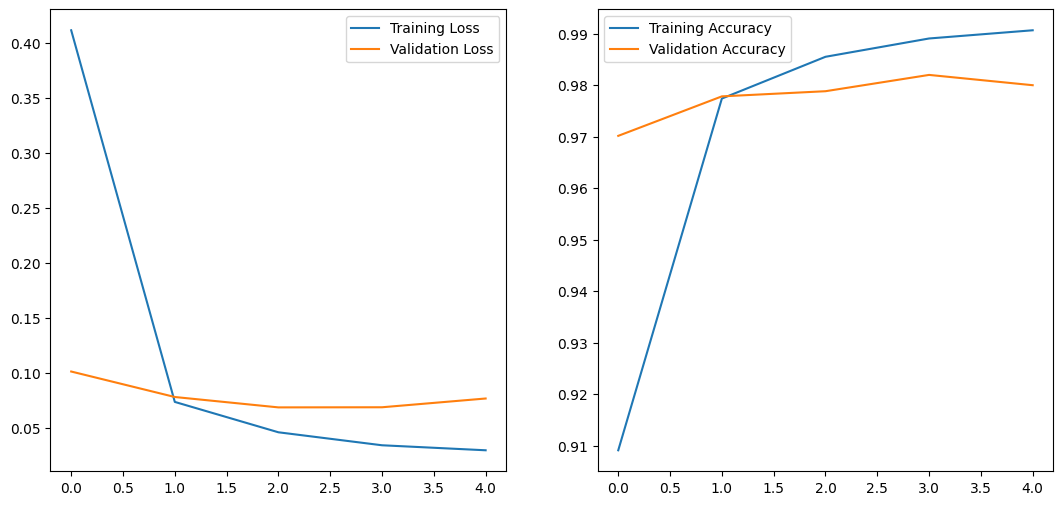

In [8]:
plot_training(history)

We can see this trained as expected and is working ok. 

Lets now do it a wrong way. Specifically, we will create a new model without the softmax, and we will use the same loss function `from_logits=False`, which is *INCORRECT* in this case because the output of the model will be a logit, and thus `from_logit` should be `True`.

In [9]:
model_logit = get_simple_network(softmax=False, name='logit')
model_logit.summary()

Model: "logit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)          4640  

In [10]:
model_logit.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])
history = model_logit.fit(mnist_train.shuffle(50000).batch(128),
                         epochs=5,
                         validation_data=mnist_val.batch(128))

Epoch 1/5
422/422 [==============================] - 4s 3ms/step - loss: 14.4181 - accuracy: 0.1044 - val_loss: 14.4418 - val_accuracy: 0.1040
Epoch 2/5
422/422 [==============================] - 2s 3ms/step - loss: 14.4343 - accuracy: 0.1045 - val_loss: 14.4418 - val_accuracy: 0.1040
Epoch 3/5
422/422 [==============================] - 1s 2ms/step - loss: 14.4344 - accuracy: 0.1045 - val_loss: 14.4418 - val_accuracy: 0.1040
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 14.4344 - accuracy: 0.1045 - val_loss: 14.4418 - val_accuracy: 0.1040
Epoch 5/5
422/422 [==============================] - 2s 5ms/step - loss: 14.4344 - accuracy: 0.1045 - val_loss: 14.4418 - val_accuracy: 0.1040


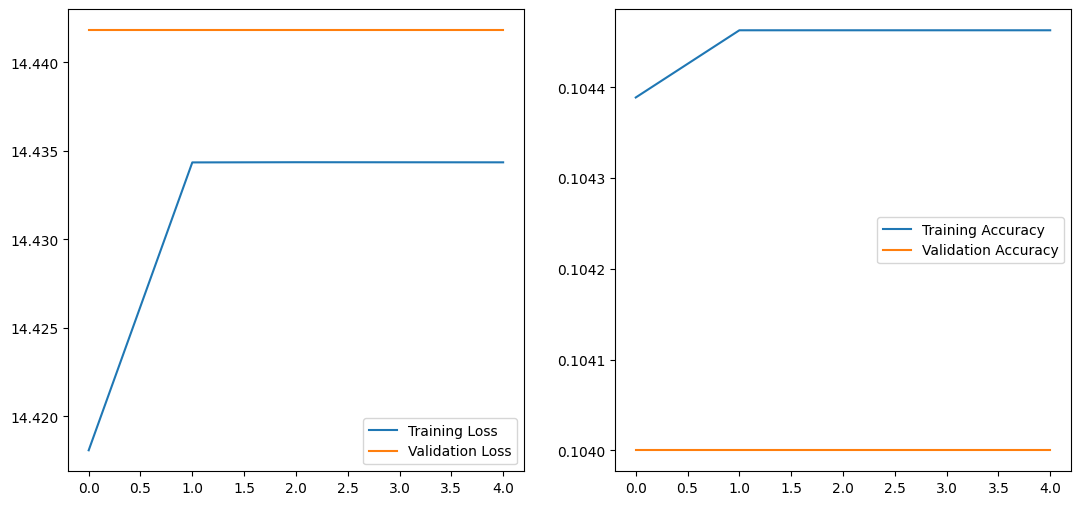

In [11]:
plot_training(history)

We can see here now that this model doesn't work at all. This is because the loss is expecting a probability, but is getting a logit.

We can correct this by setting the `from_logit=True` in the loss function.

Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 0.6723 - accuracy: 0.8946 - val_loss: 0.1265 - val_accuracy: 0.9628
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0900 - accuracy: 0.9727 - val_loss: 0.0850 - val_accuracy: 0.9753
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0561 - accuracy: 0.9823 - val_loss: 0.0723 - val_accuracy: 0.9798
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0406 - accuracy: 0.9868 - val_loss: 0.0728 - val_accuracy: 0.9793
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0303 - accuracy: 0.9904 - val_loss: 0.0797 - val_accuracy: 0.9748


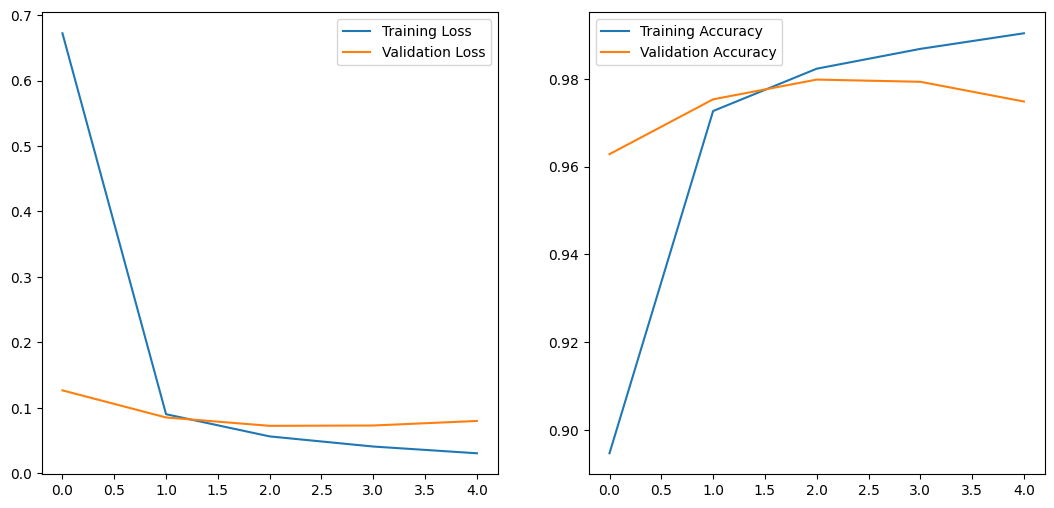

In [12]:
model_logit = get_simple_network(softmax=False, name='logit')
# from_logit is True because the output of the model is indeed a Logit
model_logit.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])
history = model_logit.fit(mnist_train.shuffle(50000).batch(128),
                         epochs=5,
                         validation_data=mnist_val.batch(128))
plot_training(history)

This now works, because the loss function will now essentially apply the Softmax function in the loss (it won't actually apply the Softmax, it will use the tricks to make it more [numerically stable](https://jaykmody.com/blog/stable-softmax/).

### Generators in the Validation Set

There are a few options for preparing data when training deep learning models in Tensorflow.

1. Raw data in numpy arrays (works fine if small dataset and can fit in memory)
2. Generators
3. `tf.data.Datasets`

For small datasets, as listed here just having them in memory as numpy arrays is totally fine. If you want to work with larger datasets (Gigabytes+) then you wont want to have everything loading into memory, you will want to just have the data/batch you are currently working on loaded in and the rest stored on disk.


Generators were typically the way to go when working with this case, but now using something like `tf.data.Datasets` is a much better option. That said there are sometimes where existing approaches with Generators might already be available and you just want to use them (like the Triplet/Siamese methods that are out there that we have adapted here in 420). This is fine but there is one thing we want to watch out for, and that is having them in the validation set.

Generators by default will just run forever. You will note in our examples that when using Generators for fitting models we have to specify the argument `steps_per_epoch` in the `fit` command. Something like 

``` python

triplet_network.fit(training_gen,
                    steps_per_epoch = dataset_size // batch_size,
                    epochs=10)

```

Since the generator runs forever, the `steps_per_epoch` argument will implictly say that once we have done `steps_per_epochs` training iterations, consider that one epoch. 

If you are using a generator for the validation set, you will also need to specify the `validation_steps` argument to [avoid an inifite loop whilst running the validation step during training](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).


In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

### Wrong number of outputs for Classification tasks

The output dimensions of your model need to be the same as the number of classes you are working with.

Example
For MNIST we have 10 classes, so the output dimension must be 10. Lets see what happens if we do it incorrectly

In [16]:
# getting mnist data
mnist_train_x, mnist_train_y = next(iter(mnist_train.batch(50000)))
# will one-hot encode the labels
mnist_train_y = keras.utils.to_categorical(mnist_train_y, 10)

In [20]:
# making an incorrect model output
model = get_simple_network(num_outputs=11, name='incorrect_outputs')
model.summary()

Model: "incorrect_outputs"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 8)         │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)          │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 64)                │    100,416 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 11)                │        715 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 107,019 (418.04 KB)

 Trainable params: 107,019 (418.04 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(mnist_train_x, mnist_train_y,
                    batch_size=64,
                    epochs=5,
                    validation_data=mnist_val.batch(128))

Epoch 1/5


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 10), output.shape=(None, 11)

We see some red wall of text to tell us the shapes are incompatible.

We can fix this by just making the output dimensions match the number of classes.

In [17]:
# making an correct model output
model = get_simple_network(num_outputs=10, name='correct_outputs')
model.summary()

Model: "correct_outputs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 32)      

In [18]:
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(mnist_train_x, mnist_train_y,
                    batch_size=64,
                    epochs=5)

Epoch 1/5
782/782 [==============================] - 7s 7ms/step - loss: 0.5673 - accuracy: 0.9086
Epoch 2/5
782/782 [==============================] - 6s 7ms/step - loss: 0.0843 - accuracy: 0.9748
Epoch 3/5
782/782 [==============================] - 5s 6ms/step - loss: 0.0589 - accuracy: 0.9817
Epoch 4/5
782/782 [==============================] - 6s 8ms/step - loss: 0.0463 - accuracy: 0.9853
Epoch 5/5
782/782 [==============================] - 6s 8ms/step - loss: 0.0359 - accuracy: 0.9883


This looks like it is working no worries now. 

One sinister thing to note is that you might only get this error if you are working with one-hot encoded labels. If the labels are integers, this error might not show up. What you might see though is that Nans will appear *IF* the output dimensions you specified are less than the number of classes

Example



In [19]:
# getting mnist data
mnist_train_x, mnist_train_y = next(iter(mnist_train.batch(50000)))
# will NOT one-hot encode the labels - they are integers by default when loaded from tfds

In [20]:
# making an inorrect model output with less output dimensions
model = get_simple_network(num_outputs=9, name='incorrect_less_outputs')
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(mnist_train_x, mnist_train_y,
                    batch_size=64,
                    epochs=5)

Epoch 1/5
782/782 [==============================] - 6s 7ms/step - loss: nan - accuracy: 0.0993
Epoch 2/5
782/782 [==============================] - 6s 7ms/step - loss: nan - accuracy: 0.0993
Epoch 3/5
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.0993
Epoch 4/5
782/782 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.0993
Epoch 5/5
782/782 [==============================] - 6s 8ms/step - loss: nan - accuracy: 0.0993


In [21]:
# making an inorrect model output with more output dimensions
model = get_simple_network(num_outputs=11, name='incorrect_more_outputs')
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(mnist_train_x, mnist_train_y,
                    batch_size=64,
                    epochs=5)

Epoch 1/5
782/782 [==============================] - 6s 6ms/step - loss: 0.3126 - accuracy: 0.9262
Epoch 2/5
782/782 [==============================] - 5s 7ms/step - loss: 0.0641 - accuracy: 0.9797
Epoch 3/5
782/782 [==============================] - 6s 7ms/step - loss: 0.0433 - accuracy: 0.9859
Epoch 4/5
782/782 [==============================] - 5s 7ms/step - loss: 0.0348 - accuracy: 0.9888
Epoch 5/5
782/782 [==============================] - 6s 7ms/step - loss: 0.0295 - accuracy: 0.9903


We see from the first one we got `NaN` loss values, but the second one actually worked no worries. It worked in the second time because we injected an additional 11th class, there was just never a data sample for it. Whilst the model _worked_ here, I would still consider this to be an error, and may not always work and will almost surely hold some underlying pathologies.

## Models Not Performing Well

It will be pretty common for you to make a model that just isn't performing well for some reason, even though you weren't getting any red walls of text and that the model seemed to "train". Some of these notes here will be to help you identify whats going on with your model for these scenarios.

The first step will be to look at the loss values during training.

Epoch 1/5
422/422 [==============================] - 3s 3ms/step - loss: 0.5544 - accuracy: 0.9011 - val_loss: 0.1169 - val_accuracy: 0.9652
Epoch 2/5
422/422 [==============================] - 3s 6ms/step - loss: 0.0863 - accuracy: 0.9733 - val_loss: 0.0784 - val_accuracy: 0.9770
Epoch 3/5
422/422 [==============================] - 3s 6ms/step - loss: 0.0506 - accuracy: 0.9846 - val_loss: 0.0743 - val_accuracy: 0.9798
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 0.0377 - accuracy: 0.9879 - val_loss: 0.0621 - val_accuracy: 0.9823
Epoch 5/5
422/422 [==============================] - 3s 6ms/step - loss: 0.0270 - accuracy: 0.9913 - val_loss: 0.0662 - val_accuracy: 0.9810


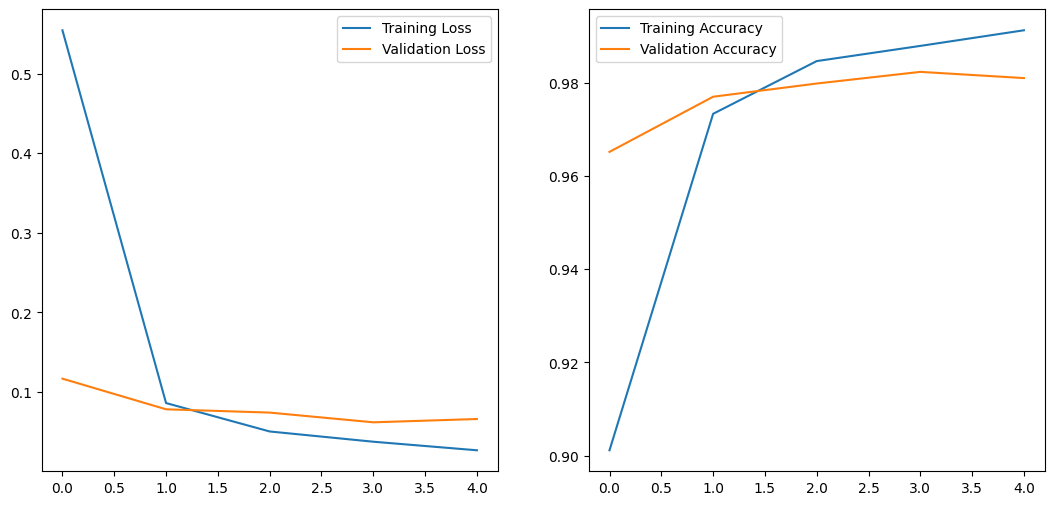

In [22]:
model = get_simple_network(num_outputs=10, name='demo')
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])
# here am just going to use a subset of the mnist data for training
# this is mainly so we can see the loss curve at a bit higher resolution
(mnist_train_subset, mnist_val_subset, mnist_test), mnist_info = tfds.load('mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
) 
history = model.fit(mnist_train_subset.shuffle(mnist_train_subset.cardinality().numpy()).batch(128),
                    epochs=5,
                    validation_data=mnist_val_subset.batch(128))
plot_training(history)

This here is an example of a model training pretty well. We can identify this by the loss curves for the training and the validation datasets. We want both of these to go down as training continues. These will eventually plateau, but what is really important is that we can see a trend of it decreasing, but can verify that the model is not overfitting or underfitting. 

We can identify overfitting if the validation loss begins to increase after a while (a sort of U shape). Overfitting means that we are basically just memorising the training data, and not identifying generalisable trends present. Remember we don't really care about predictive performance on the training data at all. What we care about is that we can learn trends from this training data that extends to new and unseen data! Underfitting means that we basically aren't able to learn enough from the data.

Lets have a look at some cases where overfitting and underfitting might occur.

For this we will move away from MNIST as it is much too simple and can actually be difficult to make a model overfit/underfit to it. For this we will look to the CIFAR-10 dataset. We will create a validation set here as well by subsetting the training data and to highlight the prominance of the problem I will make the validation set much bigger than the training set (which is atypical but should make the effects easier to see).

In [23]:
(cifar_train, cifar_val, cifar_test), cifar_info = tfds.load('cifar10',
    split=['train[:20%]', 'train[20%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# normalise the cifar training data to be in range 0, 1
def normalise(x, y):
    return tf.cast(x, tf.float32) / 255.0, y
cifar_train = cifar_train.map(normalise)
cifar_val = cifar_val.map(normalise)
cifar_test = cifar_test.map(normalise)

### Model too Complex (Overfitting)

The more complex we make a model, the more capacity it has and the more complex functions it can approximate. This sounds like a great thing, but there is a trade off. The more complex a model is, the more likely it will just memorise the training data. We also don't want to make our model too simple, otherwise we won't have the capacity needed to model problem at hand.

Lets start with a Resnet style network that is likely a bit too complex for what we are doing.

In [24]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(inputs, filters, num_res_blocks, pool_size):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.

    # Arguments
        inputs (layer):         the input tensor
        filters ([int]):        number of filters in each stage, length of list determines number of stages
        num_res_blocks (int):   number of residual blocks per stage
        pool_size (int):        size of the average pooling at the end

    # Returns
        output after global average pooling and flatten, ready for output
    """
    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0])

    # Instantiate the stack of residual units
    for stack, filters in enumerate(filters):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
 
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = GlobalAveragePooling2D()(x)
    y = Flatten()(x)

    return y


def resnet_v2(inputs, filters, num_res_blocks, pool_size):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.

    # Arguments
        inputs (layer):         the input tensor
        filters ([int]):        number of filters in each stage, length of list determines number of stages
        num_res_blocks (int):   number of residual blocks per stage
        pool_size (int):        size of the average pooling at the end

    # Returns
        output after global average pooling and flatten, ready for output
    """

    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0],
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage, filters in enumerate(filters):
        num_filters_in = filters
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    return y

In [25]:
inputs = layers.Input(shape=(32, 32, 3, ), name='img')
x = resnet_v1(inputs, [16, 32, 64, 128], 3, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.AdamW(),
              metrics=['accuracy'])

In [26]:
model_cnn.summary()

Model: "simple_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 32, 32, 16)           448       ['img[0][0]']                 
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 16)           64        ['conv2d_24[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 16)           0         ['batch_normali

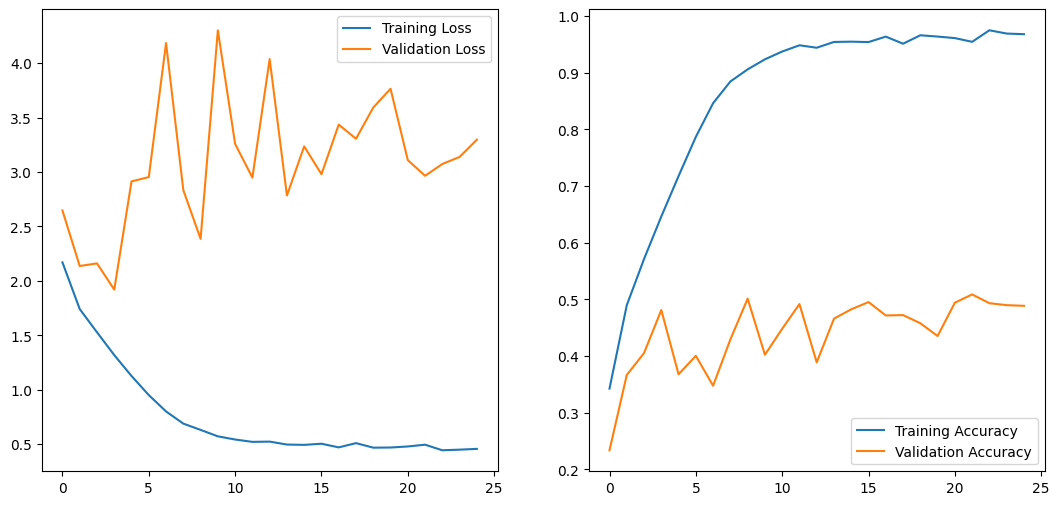

In [27]:
history = model_cnn.fit(cifar_train.shuffle(cifar_train.cardinality().numpy()).batch(64),
                       epochs=25,
                       validation_data=cifar_val.batch(64),
                       verbose=False)
plot_training(history)

Looking at the training and validation loss curves here, we can see that the validation loss is almost constantly increasing, which indicates overfitting has occured. Lets reduce the complexity of our model and see what happens.

In [28]:
inputs = layers.Input(shape=(32, 32, 3, ), name='img')
x = resnet_v1(inputs, [16, 32], 2, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.AdamW(),
              metrics=['accuracy'])

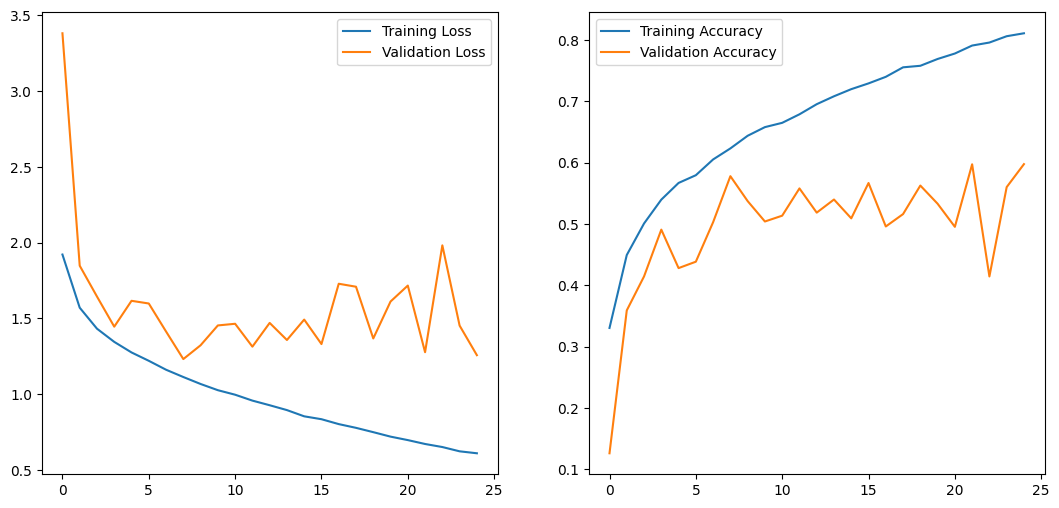

In [29]:
history = model_cnn.fit(cifar_train.shuffle(cifar_train.cardinality().numpy()).batch(64),
                        epochs=25,
                        validation_data=cifar_val.batch(64),
                        verbose=False)
plot_training(history)

The loss curve here for the validation set is still pretty eratic, but it looks like it is decreasing on average much more than that of the original model. I would say that it is still overfitting, but the effects of overfitting have been reduced.


Neither of these models are actually performing very well for this task here, but the message here is that model complexity can be a blessing and a curse, and that we need to specify the right model for the task at hand.

### Reducing the effect of Overfitting

There are a bunch of ways we can limit the effect of overfitting during training. 
The main ways I would suggest are,

1. Regularisation (Dropout, L2 norm etc.)
2. Data augmentation
3. Optimisation methods
4. Use a simpler model

In general data augmentation will get you more bang for your buck, and will allow you to use the more complex models whilst alleviating the potential for overfitting.

In the above examples, I actually used a method for regularisation known as Weight Decay, which is very similar to L2 regularisation. This is done by setting the Optimiser to `AdamW` (Adam optimiser with Weight decay).
We can try the above simpler model without weight decay and see what happens.

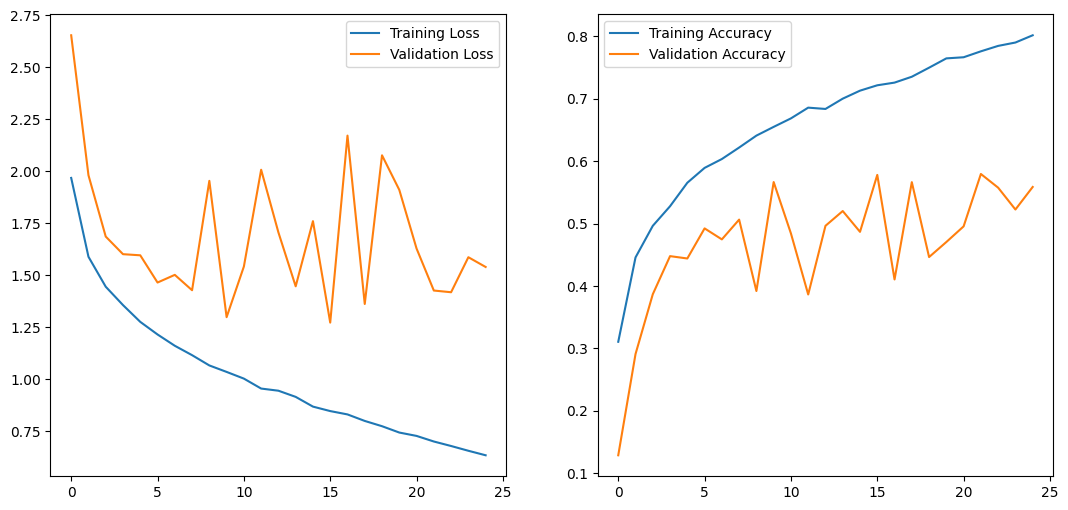

In [30]:
inputs = layers.Input(shape=(32, 32, 3, ), name='img')
x = resnet_v1(inputs, [16, 32], 2, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
# NO WEIGHT DECAY HERE NOW
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(cifar_train.shuffle(cifar_train.cardinality().numpy()).batch(64),
                       epochs=25,
                       validation_data=cifar_val.batch(64),
                       verbose=False)
plot_training(history)

The loss curve here for the validation set looks much more erratic than before, and has higher value on average. This shows that weight decay can help if overfitting is identified, but again data augmentation is much more likely to get you there. To show that lets put it to the test.

In [31]:

def augmentation(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_contrast(x, 0.8, 1.2)
    x = tf.image.random_hue(x, 0.2)
    # and a random rotation
    rot = tf.random.uniform((), minval=-0.25, maxval=0.25)
    x = tfa.image.rotate(x, rot, fill_mode='nearest')
    return x, y
cifar_train_aug = cifar_train.map(augmentation)


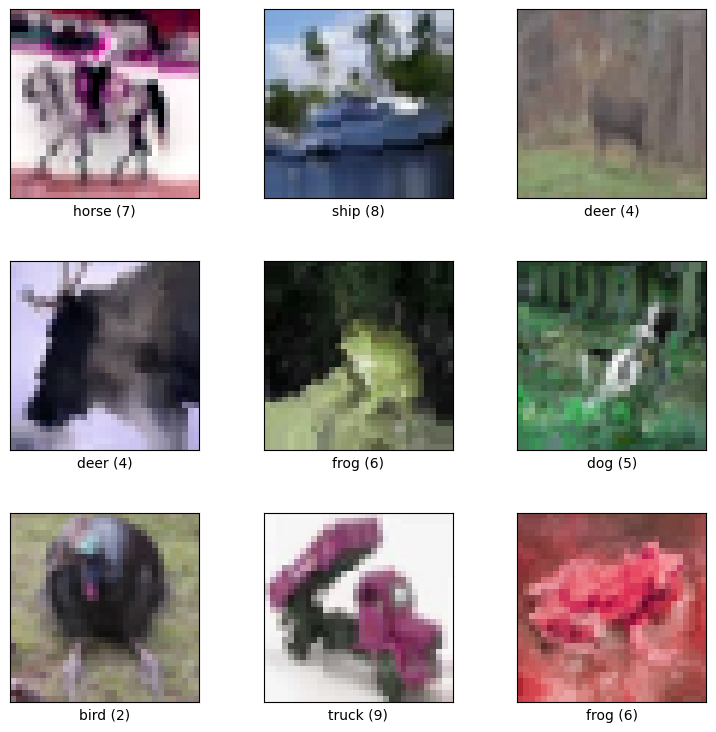

In [32]:
fig = tfds.show_examples(cifar_train_aug, cifar_info)

We will also be able to train for longer as well before the model caps out on the training data. Since now we are doing data augmentation, I will double the number of epochs here.

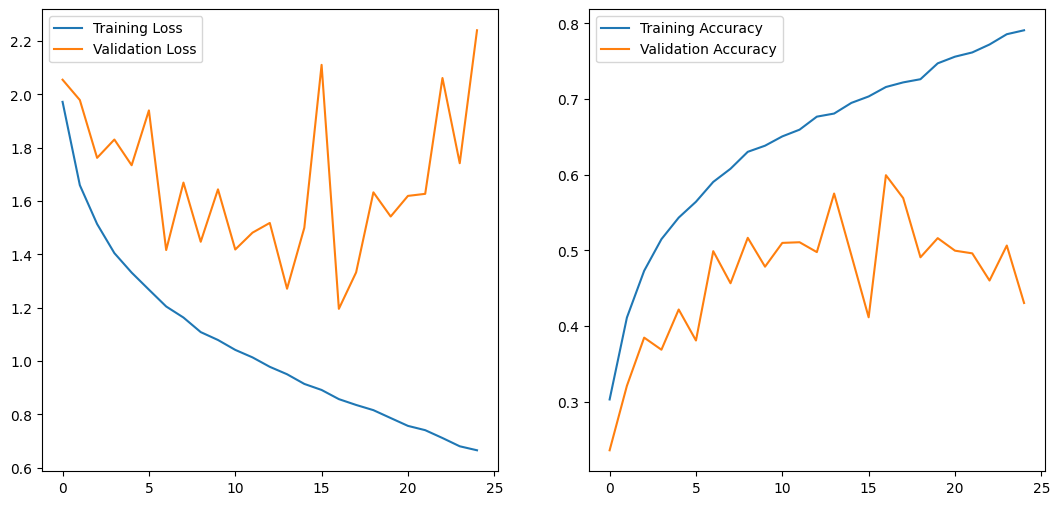

In [33]:
inputs = layers.Input(shape=(32, 32, 3, ), name='img')
x = resnet_v1(inputs, [16, 32], 2, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.AdamW(),
              metrics=['accuracy'])
history = model_cnn.fit(cifar_train.shuffle(cifar_train.cardinality().numpy()).batch(64),
                       epochs=25,
                       validation_data=cifar_val.batch(64),
                       verbose=False)
plot_training(history)

It looks like the augmentation actually didn't really help here in this case. To show I'm not a liar, lets have a look at a more realistic problem, where we will create an image classifier for a subset of the Imagenet dataset called [Imagenette](https://github.com/fastai/imagenette).

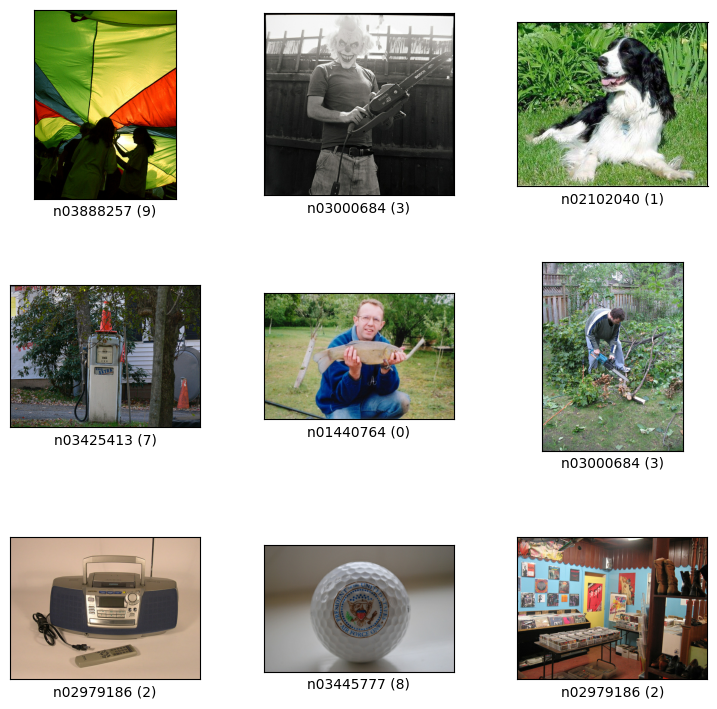

In [34]:
(img_train, img_test), img_info = tfds.load('imagenette',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
fig = tfds.show_examples(img_train, img_info)

In [35]:
def prepare_imagenette(x, y):
    x = tf.image.central_crop(x, 0.8)
    x = tf.image.resize(x, (128, 128))
    x = x / 255.0
    return x, y

img_train = img_train.map(prepare_imagenette, num_parallel_calls=tf.data.AUTOTUNE)
img_val = img_test.map(prepare_imagenette, num_parallel_calls=tf.data.AUTOTUNE)

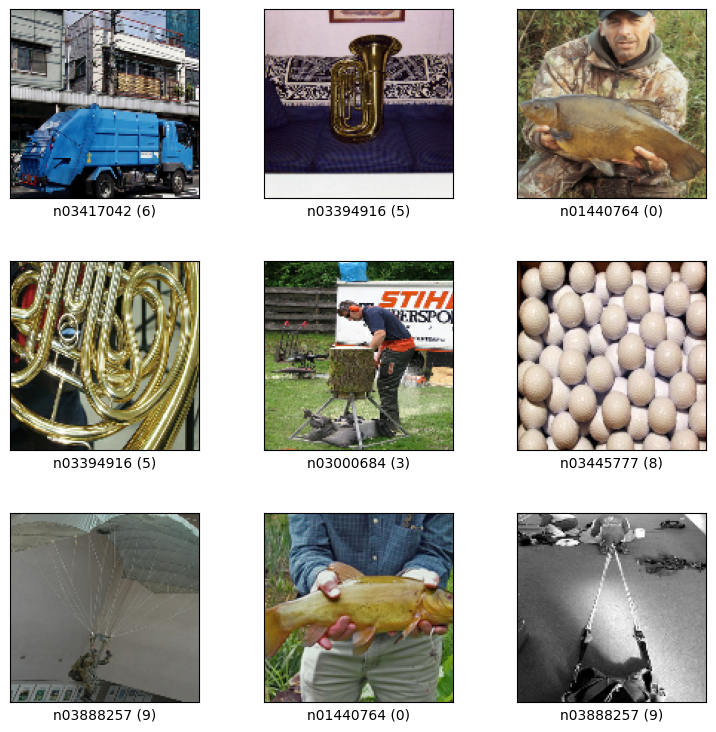

In [36]:
fig = tfds.show_examples(img_train, img_info)

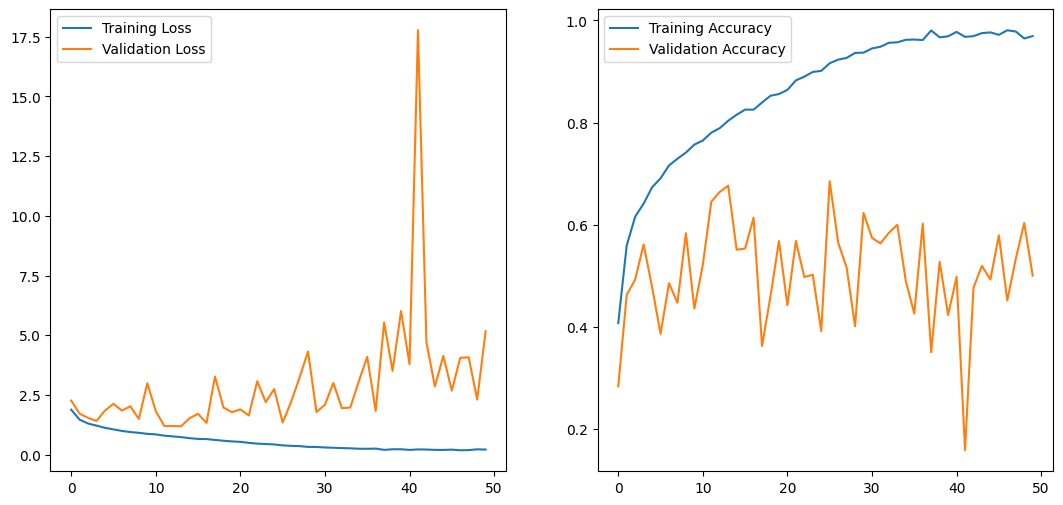

In [37]:
inputs = layers.Input(shape=(128, 128, 3, ), name='img')
x = resnet_v1(inputs, [16, 32, 64], 2, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.AdamW(),
              metrics=['accuracy'])
history = model_cnn.fit(img_train.shuffle(img_train.cardinality().numpy()).batch(64),
                       epochs=50,
                       validation_data=img_val.batch(64),
                       verbose=False)
plot_training(history)

In [38]:
def augmentation(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_contrast(x, 0.8, 1.2)
    x = tf.image.random_hue(x, 0.2)
    # and a random rotation
    rot = tf.random.uniform((), minval=-0.25, maxval=0.25)
    x = tfa.image.rotate(x, rot, fill_mode='nearest')
    return x, y
img_train_aug = img_train.map(augmentation)

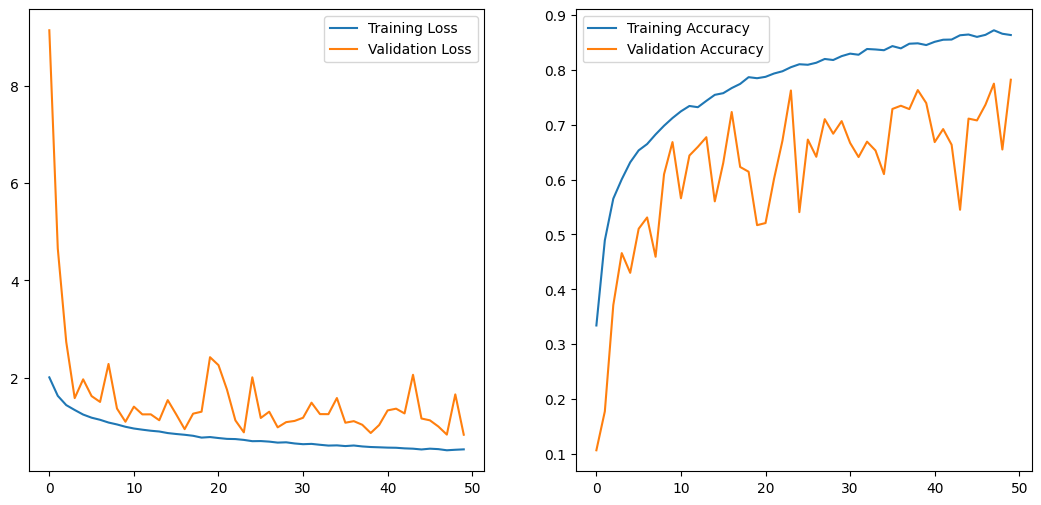

In [39]:
inputs = layers.Input(shape=(128, 128, 3, ), name='img')
x = resnet_v1(inputs, [16, 32, 64], 2, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.AdamW(),
              metrics=['accuracy'])
history = model_cnn.fit(img_train_aug.shuffle(img_train_aug.cardinality().numpy()).batch(64),
                        epochs=50,
                        validation_data=img_val.batch(64),
                        verbose=False)
plot_training(history)

Success! This shows that we have really avoided overfitting this time by using some more data augmentation.

This is to say that whilst data augmentation can help avoid overfitting, as we saw in the previous example it isn't a magic bullet. Many times it will offer improvements, but it isn't always the case, and the augmentations used must be suitable for the task at hand.

### Not Normalising/Standardising the data

Training neural networks can be tricky, and if values/gradients are too high, then we will often run into issues where the model won't train as expected in that we will get `NaNs` or the model just wont train at all. This is particularly important for image datasets.

Images are typically stored in two ways:

1. Unsigned Uint8s with range [0, 255]
2. floats with range [0, 1]

The second format is fine in most cases (it might not be ideal but our models should be able to train), but the first format isnt suitable because the range is much too high (we also would need to cast to floating point but that is typically done for us behind the scenes).

Lets see what happens when we don't normalise the data when they are in the range of [0, 255]



In [137]:
# load in the ImageNette dataset again 
(img_train, img_test), img_info = tfds.load('imagenette',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True, 
)

# am just resizing it here so is all consistent
def prepare_imagenette(x, y):
    x = tf.image.central_crop(x, 0.8)
    x = tf.image.resize(x, (128, 128))
    return x, y

img_train = img_train.map(prepare_imagenette, num_parallel_calls=tf.data.AUTOTUNE)
img_val = img_test.map(prepare_imagenette, num_parallel_calls=tf.data.AUTOTUNE)

In [138]:
# get a sample and look at the range
x, y = next(iter(img_train))
print(f'max = {np.max(x)}, min = {np.min(x)}')

max = 255.0, min = 0.0


We can see this is in the Unit8 format between the limits of [0, 255]. Lets try and train a model for this type of data. We will use the same Resnet model we used above, but will only train for 10 epochs here now for brevity.

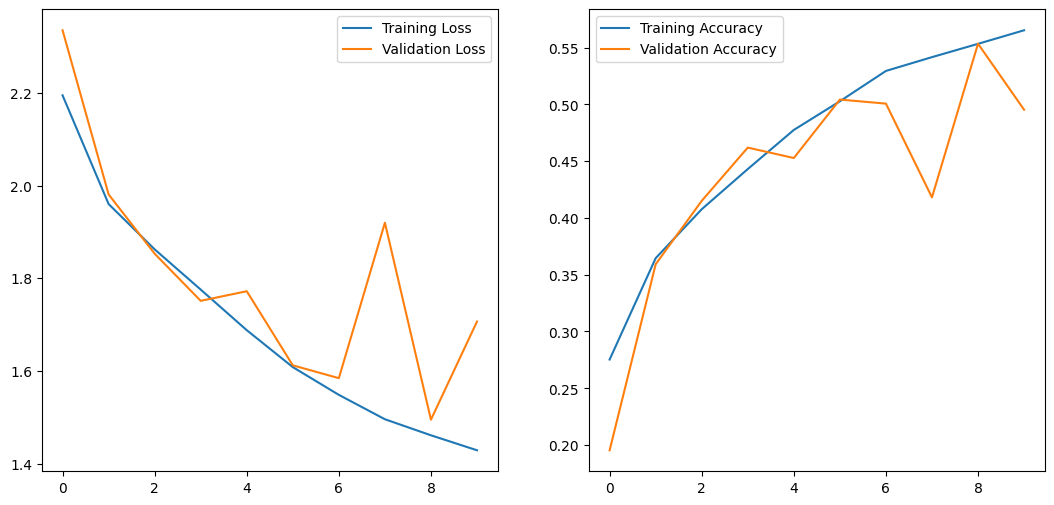

In [139]:
inputs = layers.Input(shape=(128, 128, 3, ), name='img')
x = resnet_v1(inputs, [16, 32, 64], 2, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])
history = model_cnn.fit(img_train.shuffle(img_train.cardinality().numpy()).batch(64),
                        epochs=10,
                        validation_data=img_val.batch(64),
                        verbose=False)
plot_training(history)

This is mildly annoying because it is actually working. I was kind of expecting it to just blow up/and or and not work at all. Regardless lets see how normalising things properly improves things.

In [140]:
# normalise the cifar training data to be in range 0, 1
def normalise(x, y):
    return tf.cast(x, tf.float32) / 255.0, y

img_train_norm = img_train.map(normalise)
img_val_norm = img_val.map(normalise)

# get a sample and look at the range
x, y = next(iter(img_train_norm))
print(f'max = {np.max(x)}, min = {np.min(x)}')

max = 1.0, min = 0.0


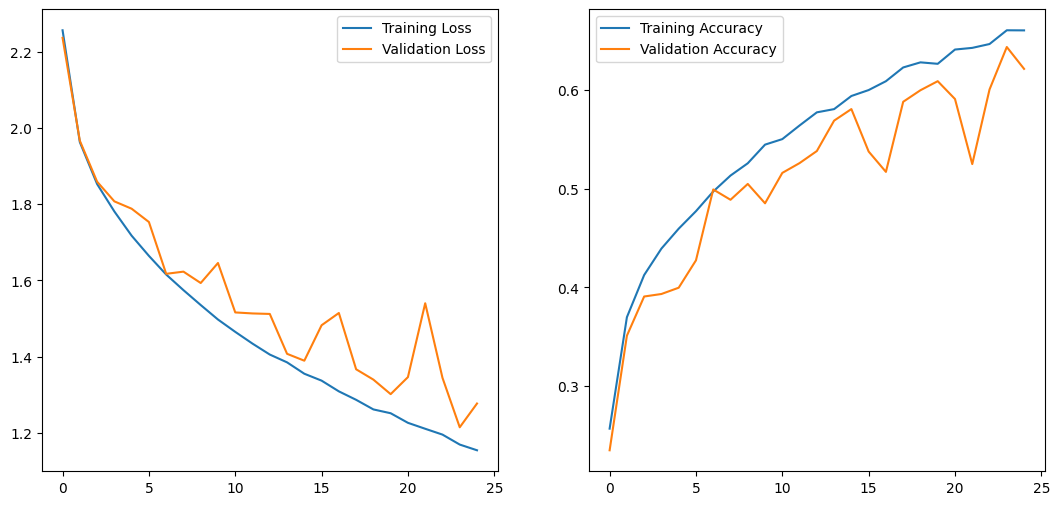

In [141]:
inputs = layers.Input(shape=(128, 128, 3, ), name='img')
x = resnet_v1(inputs, [16, 32, 64], 2, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])
history = model_cnn.fit(img_train_norm.shuffle(img_train_norm.cardinality().numpy()).batch(64),
                        epochs=25,
                        validation_data=img_val_norm.batch(64),
                        verbose=False)
plot_training(history)

It does indeed improve things. However not as much I expected. 

Regardless, it is important to make sure your data is normalised beforehand, as things can really go south if you dont (will have to trust me on this one, although Im sure more than a few people will get bitten by this one).

### Normalised/standardised training data, but not testing/Validation data

This is a super easy mistake to make and can be a bit tricky to find sometimes. Your model looks like it is training ok when you inspect the training loss curve, but having a look the validation/testing performance is crap. It is easy to think that your model is overfitting here, and it very well might be, but it is worthwhile triple checking that the both training and testing/validation data are preprocessed in the same way. 

Lets see what it looks like when this happens. We will work with a simple Conv net for MNIST here, and will normalise the training d

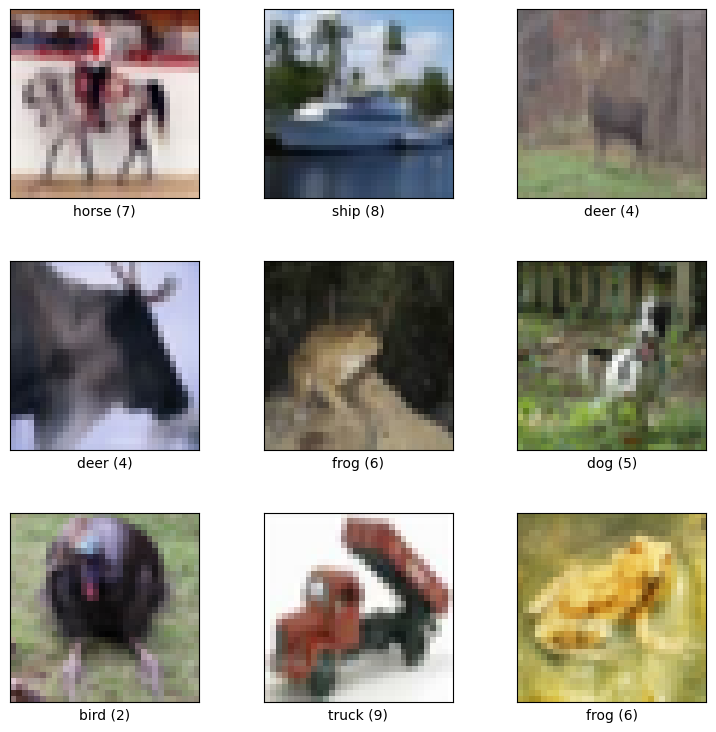

In [3]:
(cifar_train, cifar_val, cifar_test), cifar_info = tfds.load('cifar10',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

fig = tfds.show_examples(cifar_train, cifar_info)


lets see what the range of the data is in. We know images are typically in two main formats: uint8 type of range `[0, 255]`, or as floats in range `[0, 1]`.

In [4]:
# get a single sample of an image
# each value from the dataset object will be a tuple with an input image and a label
# we just want the label here now
cifar_sample = next(iter(cifar_train))[0]
print(f'Type = {cifar_sample.dtype}, max = {np.max(cifar_sample)}')


Type = <dtype: 'uint8'>, max = 249


We see has a maximum value of 255, so we need to do some processing to make it more suitable for deep learning models. Will normalise it here by just dividing by 255, and casting to a single precision floating point value.

*IMPORTANT*

You should cast to a float *BEFORE* you normalise/standardise. For integer division, it will round down to the closest integer. So say for example, if you divide a pixel value of 25 by 255, you will get $25 / 255 \approx 0.98$, which will round down to zero due to integer precision. 



In [5]:
def normalise_cifar(x, y):
    # cast input to a float, and then normalise by dividing by 255
    # which will put all pixels in the range of [0, 1]
    x = tf.cast(x, tf.float32) / 255
    return x, y

In [6]:
# map this function over the mnist training dataset
cifar_train = cifar_train.map(normalise_cifar)


Now we will train a model on the normalised data, but evaluate it on the non-normalised data and see what happens.

In [7]:
inputs = keras.Input(shape=(32,32,3), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation=None)(x)
model = keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 8)         │        224 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 16)        │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 10)                │     10,250 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 13,962 (54.54 KB)

 Trainable params: 13,962 (54.54 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(cifar_train.shuffle(cifar_train.cardinality().numpy()).batch(32), 
                    epochs=10,
                    verbose=True,
                   validation_data=(cifar_val.batch(32)))

Epoch 1/10
 120/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1618 - loss: 2.2540

I0000 00:00:1710120808.790199    2849 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710120808.798617    2849 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3559 - loss: 1.7844

W0000 00:00:1710120811.300323    2846 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710120811.990923    2845 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3559 - loss: 1.7842 - val_accuracy: 0.4362 - val_loss: 179.5639
Epoch 2/10


W0000 00:00:1710120812.340074    2847 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5307 - loss: 1.3265 - val_accuracy: 0.4080 - val_loss: 239.4360
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5822 - loss: 1.1921 - val_accuracy: 0.4614 - val_loss: 206.8922
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6065 - loss: 1.1156 - val_accuracy: 0.4152 - val_loss: 247.4797
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6278 - loss: 1.0621 - val_accuracy: 0.4370 - val_loss: 245.9236
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6393 - loss: 1.0256 - val_accuracy: 0.4380 - val_loss: 232.4206
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6497 - loss: 0.9996 - val_accuracy: 0.3614 - val_loss: 357.1016
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6601 - loss: 0.9770 - val_accuracy: 0.4012 - val_loss: 317.1163
Epoch 9/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6654 - loss: 0.9514

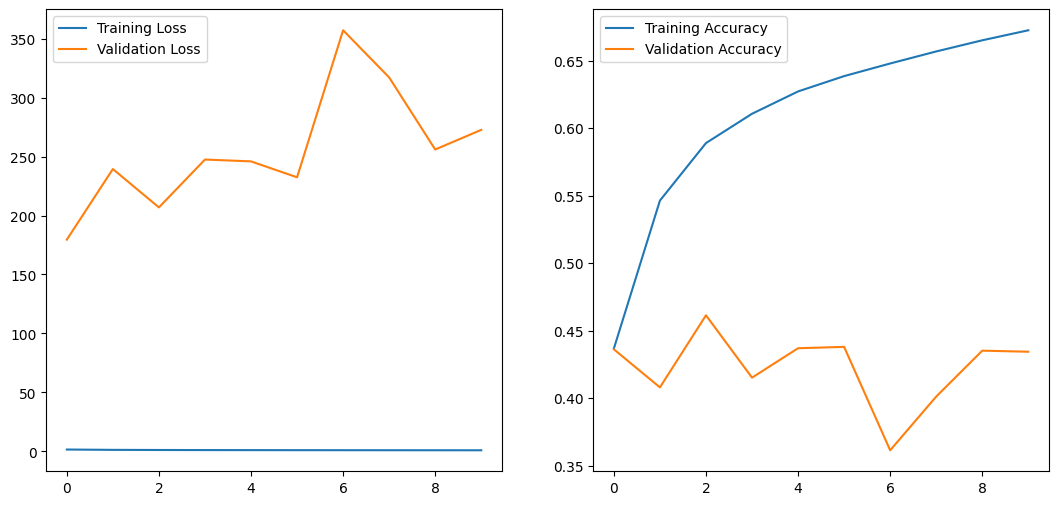

In [11]:
plot_training(history)

It definitely looks like something is wrong here. The gap between the training loss and validation loss is enormous, and the predictive performance for the validation set is pretty bad. Lets now normalise the data in the same way as the training data and see what happens. 

It wont give the pretty plot here, just looking at the final accuracy over the validation set for the trained model.

In [16]:
model.evaluate(cifar_val.map(normalise_cifar).batch(cifar_val.cardinality()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6470 - loss: 1.0196


[1.0196062326431274, 0.6470000147819519]

Awesome, now our validation performance is pretty much on par with the training set. This shows that by not preprocessing our validation/testing data in exactly* the same way as our training data, we lost approx. 20% in predictive accuracy.


This is a bit of an isidious thing to track down when things are going wrong, but hopefully this example will be a bit of a guide if this every happens to you. It is a super easy mistake to make (I have done it more than once).


_Footnote_

*In some training paradigms seen outside this class, you might not preprocess training and validation/testing data in _exactly_ the same way. This is mostly due to computational efficiency and data augmentation. For 99.9% of cases, you should not be doing any augmentation during testing phase. So for this class, we will try and call augmentation specifically, to try and not confuse it with other preprocessing methods such as normalisation/standardisation. Some state-of-the-art training schemes do some training with smaller image sizes and test on slightly larger images. This is done by the use of global average pooling for the final flattening of a conv net.

## Selecting Certain Outputs from Multi-Task models

When working with multi-task models, you often want to extract just a single output to do some further processing. Lets see how we can do this. For this example we will work with a simple auto-encoder and classification model on MNIST.

In [5]:
input_img = Input(shape=(28, 28, 1))

# encoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)

# compressed representation
encoded = layers.MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)
# at this point the representation is (4, 4, 4) i.e. 64-dimensional

# making a classification output
flat = layers.Flatten()(encoded)
class_out = layers.Dense(10, name='classification')(flat)

# decoder for autoencoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
# will use a sigmoid activation on the output since we want our predicted value to be 
# between zero and one ASSUMING WE NORMALISE OUR DATA!
# if we didnt normalise then this would break things
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)

# create the model with two outputs
# first output will be the classification out, the second will be the reconstructed input
multi = keras.Model(input_img, [class_out, decoded])

multi.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │     160 │ input_layer[0][0]    │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │       0 │ conv2d[0][0]         │
│ (MaxPooling2D)      │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14, 8) │   1,160 │ max_pooling2d[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 8)   │       0 │ conv2d_1[0][0]       │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 4)   │     292 │ max_pooling2d_1[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bottleneck          │ (None, 4, 4, 4)   │       0 │ conv2d_2[0][0]       │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 8)   │     296 │ bottleneck[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling2d       │ (None, 8, 8, 8)   │       0 │ conv2d_3[0][0]       │
│ (UpSampling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 8)   │     584 │ up_sampling2d[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling2d_1     │ (None, 16, 16, 8) │       0 │ conv2d_4[0][0]       │
│ (UpSampling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 14, 14,    │   1,168 │ up_sampling2d_1[0][… │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ flatten (Flatten)   │ (None, 64)        │       0 │ bottleneck[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling2d_2     │ (None, 28, 28,    │       0 │ conv2d_5[0][0]       │
│ (UpSampling2D)      │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ classification      │ (None, 10)        │     650 │ flatten[0][0]        │
│ (Dense)             │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ decoded (Conv2D)    │ (None, 28, 28, 1) │     145 │ up_sampling2d_2[0][… │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 4,455 (17.40 KB)

 Trainable params: 4,455 (17.40 KB)

 Non-trainable params: 0 (0.00 B)

Note in the above model definition where we called the `keras.Model()` command, our output is a list where the  first output is the classification output and the second is the decoded input. Lets see how this plays out after we train the model.

First just creating a tensorflow dataset object that will return the original image as our input, and will return a list of two outputs with the first element being the class and the second being the input again. Note the order here!

In [6]:
(mnist_train, mnist_val, mnist_test), mnist_info = tfds.load('mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


def data_classification_decoder(x, y):
    """return the inputs and outputs needed for the classification and decoder

    Params
    ------
    x:
      image input
    y:
      classification labels

    Returns
    -------
    original input, [classification label, original input for decoder]
    """
    # will also one-hot encode the classification labels, is generally a good idea.
    class_labels = tf.one_hot(y, 10)
    # also normalise mnist
    img = x / 255
    return img, (class_labels, img)
    

mnist_train_multi = mnist_train.map(data_classification_decoder)
mnist_val_multi = mnist_val.map(data_classification_decoder)
mnist_test_multi = mnist_test.map(data_classification_decoder)

Now lets compile and train the model. Again note the order of how we specify things for the loss functions. First loss will be a categorical cross entropy because the first task is classification, and the second will be a mean squared error term for the auto encoder.

In [7]:
multi.compile(loss=[keras.losses.CategoricalCrossentropy(from_logits=True), keras.losses.MeanSquaredError()],
              optimizer=keras.optimizers.SGD(momentum=0.9),
              metrics=['accuracy', 'mean_squared_error'])
history = multi.fit(mnist_train_multi.shuffle(mnist_train_multi.cardinality().numpy()).batch(32), 
                    epochs=10,
                    verbose=True)

Epoch 1/10
  99/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - classification_accuracy: 0.1301 - decoded_mean_squared_error: 0.1667 - loss: 2.4535

I0000 00:00:1710132695.515570   13801 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - classification_accuracy: 0.7008 - decoded_mean_squared_error: 0.0779 - loss: 0.9376
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - classification_accuracy: 0.9620 - decoded_mean_squared_error: 0.0431 - loss: 0.1664
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - classification_accuracy: 0.9689 - decoded_mean_squared_error: 0.0382 - loss: 0.1413
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - classification_accuracy: 0.9732 - decoded_mean_squared_error: 0.0352 - loss: 0.1185
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - classification_accuracy: 0.9765 - decoded_mean_squared_error: 0.0335 - loss: 0.1103
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - classification_accuracy: 0.9790 - decoded_mean_squared_error: 0.0322 - loss: 0.1024
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - classification_accuracy: 0.9784 - decoded_mean_squared_error: 0.0313 - loss: 0.1020
Epoch 8/10
1688/1688 ━━━━━━━━━━

Now lets have a look at the outputs. The first output will be the classification output, the second will be the reconstructed image from the autoencoder.

In [8]:
pred_labels, recon_imgs = multi.predict(mnist_train_multi.batch(32))

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


Text(0.5, 1.0, 'predicted label = 1')

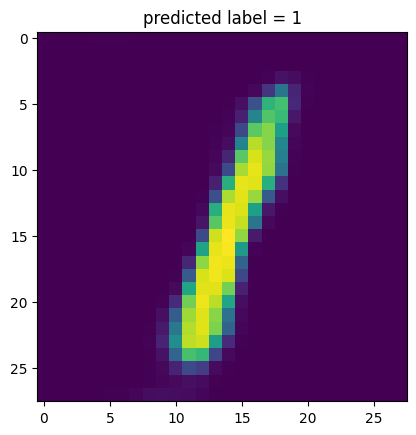

In [11]:
plt.imshow(recon_imgs[1])
plt.title(f'predicted label = {np.argmax(pred_labels[1], axis=0)}')

(28, 28, 1)


## Model not running at all (Getting some Red Walls of Text)

It happens. Things just don't work sometimes. This section walks through some common hard errors and how you can fix them.


### Not putting a Flatten Layer before your Dense layers in your network

For image models, we are working with 3D arrays of dimension $[$Height, Width, Channels$]$

Actually it will be 4D when we add the batch dimension, so $[$Batch Size, Height, Width, Channels$]$, but will ignore the Batch dimension for now and just stick with 3D to make things simpler.

Dense layers operate over vectors, which is appropriate for the types of final classification/regression outputs we are often interested in, but Convolutional layers operate over 3-dimensions (it actually can be higher dimensions but pretty much all 3D for this course). Ie. for an image classification model, we want to create a network that will map from,

$$
\mathbb{R}^3 \rightarrow \mathbb{R}^1.
$$

In english, we want to map from the 3D input $\mathbb{R}^3$ to a 1-dimensional vector output $\mathbb{R}^1$ that represents the categorical probability of each of the classes. This means that at some stage we will need to make our model go from the 3D representation from convolutional layers. We typically do this by just incorporating a flatten layer after our Convolutional backbone/encoder. Lets see what happens when we don't do that.


In [20]:
(mnist_train, mnist_val, mnist_test), mnist_info = tfds.load('mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [30]:
inputs = keras.Input(shape=(28,28,1), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Dense(10, activation=None)(x)
bad_model = keras.Model(inputs=inputs, outputs=x)
bad_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 8)         │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 10)                │      7,850 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 9,098 (35.54 KB)

 Trainable params: 9,098 (35.54 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
bad_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.AdamW(),
                  metrics=['accuracy'])
history = bad_model.fit(mnist_train.shuffle(mnist_train.cardinality().numpy()).batch(32), 
                        epochs=2,
                        verbose=True,
                       validation_data=(mnist_val.batch(32)))

Epoch 1/2
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9535 - loss: 0.1668 - val_accuracy: 0.9727 - val_loss: 0.0951
Epoch 2/2
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9737 - loss: 0.0871 - val_accuracy: 0.9755 - val_loss: 0.0867


We should be able to see here where the error is occuring. Have a look at the output dimensions for our model here. We are performing a classification task, so we would want the output dimension of the final layer to be something like `[None, Number of classes]`, but we have `[None, Height, Width, Channels]`. This is because we didn't add a flatten layer to our model, so the output is still of dimensions suitable for convolutional layers, not a classification output.

In [51]:
x, y = next(iter(mnist_train))
print(y)

tf.Tensor(4, shape=(), dtype=int64)


In [57]:
bad_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.AdamW(),
              metrics=['accuracy'])
history = bad_model.fit(mnist_train.shuffle(mnist_train.cardinality().numpy()).batch(32), 
                        epochs=2,
                        verbose=True)


Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node Equal defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_163589/1990976885.py", line 4, in <module>

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1155, in train_step

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1249, in compute_metrics

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/metrics/accuracy_metrics.py", line 459, in sparse_categorical_accuracy

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 969, in sparse_categorical_matches

required broadcastable shapes
	 [[{{node Equal}}]] [Op:__inference_train_function_583720]

We see we get an error here, and it the error message is unfortunately not that informative. I would of hoped it would say exactly that there is a shape mismatch at the dense layer. I suspect the reason we didn't get an informative error message was because we are using integers for the labels instead of one-hot encoded vectors. Lets see what happens if we do use one hot encoded labels.

In [66]:
# a function that will convert the integer labels to one-hot categorical vectors
def to_categorical(x, y):
    return x, tf.one_hot(y, 10)
    
mnist_train_cat = mnist_train.map(to_categorical)

In [71]:
# recompile the model with the normal CategoricalCrossentropy now (not the Sparse one!)
bad_model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.AdamW(),
              metrics=['accuracy'])

history = bad_model.fit(mnist_train_cat.shuffle(mnist_train.cardinality().numpy()).batch(32), 
                        epochs=2,
                        verbose=True)

Epoch 1/2


ValueError: in user code:

    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 10) and (None, 7, 7, 10) are incompatible


There we go, now we get a bit more info on some incompatible shapes, but I still would of hoped that it would of given me some more info around it occuring at the Dense layer.

Lets see what happens when we correct this by including a flatten layer before the dense layer.

In [59]:
inputs = keras.Input(shape=(28,28,1), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation=None)(x)
better_model = keras.Model(inputs=inputs, outputs=x)
better_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_122 (Conv2D)         (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 14, 14, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_123 (Conv2D)         (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 7, 7, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 784)               0   

In [60]:
better_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     optimizer=keras.optimizers.AdamW(),
                     metrics=['accuracy'])
history = better_model.fit(mnist_train.shuffle(mnist_train.cardinality().numpy()).batch(32), 
                           epochs=2,
                           verbose=True)

Epoch 1/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.8212 - accuracy: 0.9058
Epoch 2/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1057 - accuracy: 0.9681


Hey, now it trains!

### CategoricalCrossentropy or SparseCategoricalCrossentropy?


The demo just above shows some info on the difference between the Sparse and normal categorical cross entropy loss functions. 

*TLDR;*

- if your labels are one-hot encoded vectors (something like $[0, 0, 0, 1, 0, 0]$, use `CategoricalCrossentropy`
- if your labels are integers, use `SparseCategoricalCrossentropy`

Example,

In [57]:
# looking at the MNIST dataset we loaded in from tensorflow datasets earlier.
# will get a single sample and look at the labels
x, y = next(iter(mnist_train))
print(y)

tf.Tensor(4, shape=(), dtype=int64)


It is in integer format, so need to use `SparseCategoricalCrossentropy`

In [58]:
inputs = keras.Input(shape=(28,28,1), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation=None)(x)
model = keras.Model(inputs=inputs, outputs=x)

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     optimizer=keras.optimizers.AdamW(),
                     metrics=['accuracy'])
history = model.fit(mnist_train.shuffle(mnist_train.cardinality().numpy()).batch(32), 
                           epochs=1,
                           verbose=True)

 145/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4430 - loss: 9.6429 

W0000 00:00:1710123805.764170    2846 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8072 - loss: 1.9860


Lets see what happens if we specify it incorrectly.


In [77]:
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                     optimizer=keras.optimizers.AdamW(),
                     metrics=['accuracy'])
history = model.fit(mnist_train.shuffle(mnist_train.cardinality().numpy()).batch(32), 
                           epochs=1,
                           verbose=True)

ValueError: in user code:

    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


We get a shape error. We can one-hot encode our labels if we like using the [tf.one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot) function. We did it above for a tensorflow Dataset object, but will do it here again for completeness.

In [80]:
# a function that will convert the integer labels to one-hot categorical vectors
def to_categorical(x, y):
    return x, tf.one_hot(y, 10)
    
mnist_train_cat = mnist_train.map(to_categorical)

Now try train with `CategoricalCrossentropy`

In [83]:
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                     optimizer=keras.optimizers.AdamW(),
                     metrics=['accuracy'])
# NOTE - have changed dataset to the mnist_train_cat version
history = model.fit(mnist_train_cat.shuffle(mnist_train.cardinality().numpy()).batch(32), 
                           epochs=1,
                           verbose=True)

1688/1688 [==============================] - 7s 3ms/step - loss: 0.1060 - accuracy: 0.9691


Works as expected. What if I go the otherway and use `SparseCategoricalCrossentropy` here?

In [84]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     optimizer=keras.optimizers.AdamW(),
                     metrics=['accuracy'])
# NOTE - have changed dataset to the mnist_train_cat version
history = model.fit(mnist_train_cat.shuffle(mnist_train.cardinality().numpy()).batch(32), 
                           epochs=1,
                           verbose=True)

InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_163589/3529410303.py", line 5, in <module>

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [320]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_616317]

We get another shape error here. This is a pretty easy mistake to make, so hopefully this here will give you some guidance on what to do if you encounter a problem like this.

In general I would suggest using One-hot encoded variables for your labels whenever you can, as the information you get when things go wrong is a bit more informative. You can use the `tf.one_hot` method on normal numpy arrays as well if you like, but note it will return a `tf.Tensor` and not a `np.Array`

In [87]:
print(tf.one_hot([1,2,3,4], 10))

tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]], shape=(4, 10), dtype=float32)


If you really want just Numpy arrays, can use the `keras.utils.to_categorical` function. Will do the same thing but return a `np.Array`.

In [88]:
print(keras.utils.to_categorical([1,2,3,4], 10))

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


To show this in action, I will do it in the next section.

### Order of Inputs and Outputs

The general order of inputs and outputs with Tensorflow/Keras models is `input, output`.

For example, when calling a model for fitting it, you would say,

``` python
model.fit(x, y, 
          epochs=1,
          verbose=True)
```

This is done by Tensorflow Datasets as well. Lets see what happens if we do it incorrectly.

In [89]:
# lets get a subset of the mnist dataset and extract it from the tf.Dataset object so is just numpy arrays
mnist_sub_x, mnist_sub_y = next(iter(mnist_train.batch(100)))

print(mnist_sub_x.shape, mnist_sub_y.shape)

(100, 28, 28, 1) (100,)


In [90]:
# lets convert the labels to one hot encoded vectors 
# using keras.utils.to_categorical here, but could of used tf.one_hot if I really wanted.
mnist_sub_y = tf.keras.utils.to_categorical(mnist_sub_y, 10)

In [91]:
# creating a simple model again
inputs = keras.Input(shape=(28,28,1), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation=None)(x)
model = keras.Model(inputs=inputs, outputs=x)

# USING NORMAL CrossEntropy here because have one-hot encoded 
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                     optimizer=keras.optimizers.AdamW(),
                     metrics=['accuracy'])


In [93]:
history = model.fit(mnist_sub_x, mnist_sub_y,
                    epochs=1,
                    verbose=True)

4/4 [==============================] - 1s 35ms/step - loss: 112.6880 - accuracy: 0.0700


Trains no worries. Lets see what happens if I have the inputs and outputs the wrong way around?

In [95]:
history = model.fit(mnist_sub_y, mnist_sub_x,
                    epochs=1,
                    verbose=True)

ValueError: in user code:

    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ethan/miniconda3/envs/cab420_24/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_9" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(None, 10)


A nice big ole error message. Is pretty informative in telling us exactly where the error occured. We can see that the shape error is showing us that our input expected something of dimensions `[Batch size, height, width, channels]`, but we gave it just `[Batch 
size, Number of classes]`. 

Note that the size of `None` here as the first index is to indicate that this dimension can be any positive number, as this is our batch size. We have control over the batch size that we use and can use as big or as small of a batch size as required.

## Wrong Dimensions for Inputs or Outputs

Just about all the deep learning models we are working with in this class will expect a single specification for input and output dimensions of your data*. If you get it wrong, Tensorflow will usually complain at you pretty loudly to let you know, but is a super common error so will show some examples here.


_Footnote_

\* If your model is fully convolutional (maybe an autoencoder, semantic segmentation model, etc.), you can get away with changes in the height or width of your input/output images. However during training they will all need to be the same size so that things can be optimised properly during training, and they will still need to be valid image dimensions. It is common for state of the art methods to use slightly smaller image dimensions during training and then evaluate on slightly larger images. This type of approach is overkill for this class so I wouldn't worry about it, but just mentioning here for people interested. This approach can also be done for classification conv-nets if you utilise `GlobalAveragePooling` at the end before you flatten, and many state-of-the-art training approaches do a similar thing. 

Lets keep working with MNIST here. Lets set the input dimensions to something wrong and see what happens. MNIST data is $[28, 28]$, so lets set it to somethiong else on purpose.

In [60]:
# THIS NEXT LINE HAS THE MISTAKE
inputs = keras.Input(shape=(32,32,3), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation=None)(x)
bad_model = keras.Model(inputs=inputs, outputs=x)
bad_model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 8)         │        224 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 16, 16, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 8, 8, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_11 (Flatten)            │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 10)                │     10,250 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 11,642 (45.48 KB)

 Trainable params: 11,642 (45.48 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
bad_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.AdamW(),
                  metrics=['accuracy'])


history = bad_model.fit(mnist_train.shuffle(mnist_train.cardinality().numpy()).batch(32),
                        epochs=1,
                        verbose=True)

ValueError: Input 0 of layer "functional_35" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 28, 28)

Ok cool, the error message here is pretty informative and tells us pretty much exactly what happened. 


Lets see what happens if our output dimensions are wrong. MNIST has 10 classes, so the number of units for our final dense layer should be 10. Lets do it wrong and see what happens.

In [62]:
inputs = keras.Input(shape=(28,28,1), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
#x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
# THIS NEXT LINE HAS THE MISTAKE
x = layers.Dense(11, activation=None)(x)
bad_model2 = keras.Model(inputs=inputs, outputs=x)
bad_model2.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 8)         │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 14, 14, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_40 (Conv2D)              │ (None, 14, 14, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_12 (Flatten)            │ (None, 3136)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_18 (Dense)                │ (None, 11)                │     34,507 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 35,755 (139.67 KB)

 Trainable params: 35,755 (139.67 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
bad_model2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.AdamW(),
                  metrics=['accuracy'])

history = bad_model2.fit(mnist_train.shuffle(mnist_train.cardinality().numpy()).batch(32),
                         epochs=1,
                         verbose=True)

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8634 - loss: 1.4642


This should of given me an error, but it didn't. I have 10 classes in my dataset and I said the output dimension was 11. Why no red wall of text?


The issue here is that my labels are specified as integers. This means that Tensorflow is internally calling the [tf.one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot) function to convert the labels to a vector, and is creating them with 11 elements. The 11th element will never have an entry, but the model will still technically run fine. This can either be harmless or detremental. More likely than not is harmless, but still is something I would really try to avoid, and another reason I recommend converting any data into a categorical vector manually if needed.


What happens if instead I specify 9 classes in my model, but I really have 10.

In [66]:
inputs = keras.Input(shape=(28,28,1), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
#x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
# THIS NEXT LINE HAS THE MISTAKE
x = layers.Dense(9, activation=None)(x)
bad_model3 = keras.Model(inputs=inputs, outputs=x)
bad_model3.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_43 (Conv2D)              │ (None, 28, 28, 8)         │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_44 (Conv2D)              │ (None, 14, 14, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_14 (Flatten)            │ (None, 3136)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_20 (Dense)                │ (None, 9)                 │     28,233 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 29,481 (115.16 KB)

 Trainable params: 29,481 (115.16 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
bad_model3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.AdamW(),
                  metrics=['accuracy'])

history = bad_model3.fit(mnist_train.shuffle(mnist_train.cardinality().numpy()).batch(32),
                         epochs=1,
                         verbose=True)

 149/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0905 - loss: nan

W0000 00:00:1710124646.266359    2846 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0953 - loss: nan 


Here we are getting `NaN` values for our loss. This is someways unfortunate, I really would of liked tensorflow to give me an explicit shape mismatch error here, as this would tell me exactly where the error is coming from.

Lets do it now where we convert the integer labels into categorical vectors to work with and see what happens if we have the output dimensions wrong.

In [68]:
def to_categorical(x, y):
    return x, tf.one_hot(y, 10)
    
mnist_train_cat = mnist_train.map(to_categorical)

In [69]:
inputs = keras.Input(shape=(28,28,1), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
#x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
# THIS NEXT LINE HAS THE MISTAKE
x = layers.Dense(9, activation=None)(x)
bad_model4 = keras.Model(inputs=inputs, outputs=x)
bad_model4.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_45 (Conv2D)              │ (None, 28, 28, 8)         │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_46 (Conv2D)              │ (None, 14, 14, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_15 (Flatten)            │ (None, 3136)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_21 (Dense)                │ (None, 9)                 │     28,233 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 29,481 (115.16 KB)

 Trainable params: 29,481 (115.16 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:

# Changing to normal cross entropy as now our labels are one-hot encoded
bad_model4.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.AdamW(),
                  metrics=['accuracy'])

history = bad_model4.fit(mnist_train.shuffle(mnist_train.cardinality().numpy()).batch(32),
                         epochs=1,
                         verbose=True)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 9)

This is what I was looking for. A meaningful error message that tells me exactly what went wrong and almost directly tells me where to look. Either the problem is in the dimensions of my data or my model, and in this case we know it is in the model because we made it this way.

## Keras JIT/XLA Error

JIT = Just In Time compilation. Allows us to compile things on the fly just when we need things and speed up a few ops.
XLA = The compiler that is used.


There is an error on the QUT Jupyterlab instance that makes the jit compile commands not work, so we need to specify the `jit_compile=False` flag in the `model.compile()` calls, otherwise we will run into some errors. All the examples above don't include this flag because I ran them all on a local machine I have full access and control over, which means I can fix any errors that pop up and cause such things, however on the QUT instance we don't have this luxury.

To demo the effect of this, the following few code blocks are run on the QUT Jupyterlab instance so you can see what error messages occur.

In [ ]:
(mnist_train, mnist_val, mnist_test), mnist_info = tfds.load('mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# normalise mnist
def normalise(x, y):
    return x / 255, y

mnist_train = mnist_train.map(normalise)
mnist_val = mnist_val.map(normalise)
mnist_test = mnist_test.map(normalise)
print(mnist_info)

In [6]:
model = get_simple_network(softmax=False, name='softmax')
model.summary()

Model: "softmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,954 (417.79 KB)

 Trainable params: 106,954 (417.79 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(mnist_train.shuffle(50000).batch(128),
                    epochs=5,
                    validation_data=mnist_val.batch(128))


Epoch 1/5
 51/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1863 - loss: 5.5879

I0000 00:00:1710134093.498453     394 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.2764 - loss: 4.0637 - val_accuracy: 0.2063 - val_loss: 2.3026
Epoch 2/5
327/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2161 - loss: 2.3025

InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_77/2539097709.py", line 4, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.graph.launch' failed: Failed to update gpu graph: Graph update result=kTopologyChanged: Failed to update CUDA graph: CUDA_ERROR_GRAPH_EXEC_UPDATE_FAILURE: the graph update was not performed because it included changes which violated constraints specific to instantiated graph update; current profiling annotation: XlaModule:#hlo_module=a_inference_one_step_on_data_2100__.929,program_id=108#.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_2177]

Here is the error that occured so you know what to expect, what it means, and how we will fix it.

We will fix it by setting the `model.compile(jit_compile=False)` flag. We will loose a small amount of performance here, but it will be pretty minimal for what we are doing in this class here.

In [9]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'],
             # disable JIT compilation
              jit_compile=False)
history = model.fit(mnist_train.shuffle(50000).batch(128),
                    epochs=5,
                    validation_data=mnist_val.batch(128))

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7383 - loss: 0.8846 - val_accuracy: 0.9598 - val_loss: 0.1375
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9620 - loss: 0.1215 - val_accuracy: 0.9755 - val_loss: 0.0799
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9769 - loss: 0.0746 - val_accuracy: 0.9798 - val_loss: 0.0646
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9801 - loss: 0.0631 - val_accuracy: 0.9822 - val_loss: 0.0591
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9843 - loss: 0.0489 - val_accuracy: 0.9838 - val_loss: 0.0559


#### Success :)

# Where to from here?

The motivation for writing this example document was to show a bunch of the common mistakes students in the past have made, and some of the mistakes that I have made when working with Tensorflow and Keras. Want you to learn from my mistakes :)


With all that said, it is impossible to capture all possible errors and difficulties that might pop up when working with this stuff. For further help my main suggestions __in order__ would be,

1. Google - This should be your first port of call. If you are having an issue, more often then not someone else has already had the same problem. Start by googling just the last line of the error message, and more often than not the first response will be a stack overflow question that some kind sole has already answered for you. This is the best and fastest way to get answers to a lot of your questions
2. [Read the Manual](https://www.explainxkcd.com/wiki/index.php/293:_RTFM). All the packages we used or well engineered and thoroughly documented. The documentation is designed to show you how to use pretty much every tool covered in the class and avoid some common traps (This is what Simon and myself did to write all the stuff for this unit, and what you as practicing engineers/data scientists/responsible adults will have to do in the real-world anywho).
3. Lectures and Tutorials - Simon covers a bunch of this stuff in the lecture examples, and so do we in the tutes. The way I (Ethan) try to run my tutes is in a less formal way to show you how I fix all the errors that pop up know and then. If you aren't coming along to the lectures and tutes, you are really going to make things harder than needed.
4. Slack Channel - If all the above aren't helping, ask on our slack channel. The invite link is listed in the Week 0 module. Before you ask I would do a quick search to see if others have had the same issue, and if they have the answer to their problem is likely already there. If it isn't, feel free to ask and we will do our best to help
5. Don't fret if you are still having troubles. If you have tried all of the above come and flag one of us down in the tutes/lectures and we can point you in the right direction.